In [1]:
import numpy as np
import matplotlib.pyplot as plt

# Data generation

## Generate random data

In [2]:
np.random.seed(42)

In [3]:
NDIM = 2
N = 50

In [4]:
# arrays = np.random.rand(N, NDIM)
arrays = np.load('arrays.npy')

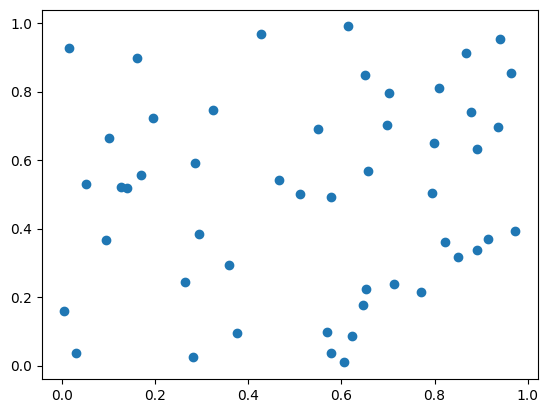

In [5]:
plt.scatter(arrays[:,0], arrays[:,1])
plt.show()

## Generate query vector

In [6]:
# query_vector = np.random.rand(NDIM)
query_vector = np.load('query_vector.npy')

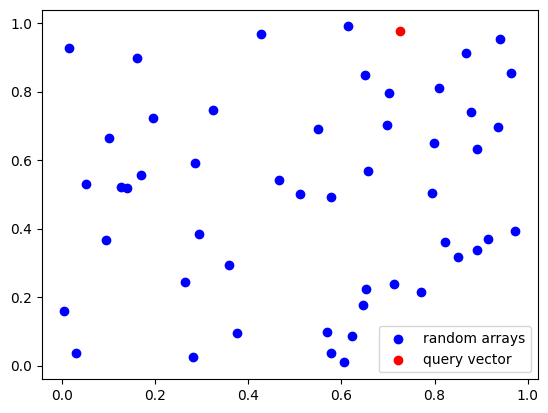

In [7]:
plt.scatter(arrays[:,0], arrays[:,1], c='blue', label='random arrays')
plt.scatter(query_vector[0], query_vector[1], c='red', label='query vector')
plt.legend()
plt.show()

In [8]:
# np.save('arrays.npy', arrays)
# np.save('query_vector.npy', query_vector)

# Complete Search

In [9]:
def search_pipeline(data, query, distance_fn):
    shortest_distance = distance_fn(query, data[0])
    best_index = 0

    compare = lambda x, y: x < y

    for i in range(1, data.shape[0]):
        distance = distance_fn(query, data[i])
        if distance < shortest_distance:
            shortest_distance = distance
            best_index = i

    print(f"{shortest_distance=}")
    print(f"{best_index=}")

    plt.scatter(data[:,0], data[:,1], c='blue', label='random arrays')
    plt.scatter(query[0], query[1], c='red', label='query vector')
    plt.scatter(data[best_index,0], data[best_index,1], c='green', label='closest vector')
    plt.plot([query[0], data[best_index,0]],
            [query[1], data[best_index,1]], 'k-')

    plt.legend()
    plt.show()

## L1

In [10]:
def distance_l1(vec1, vec2):
    return np.linalg.norm(vec1-vec2, 1)

shortest_distance=0.12528587766522048
best_index=29


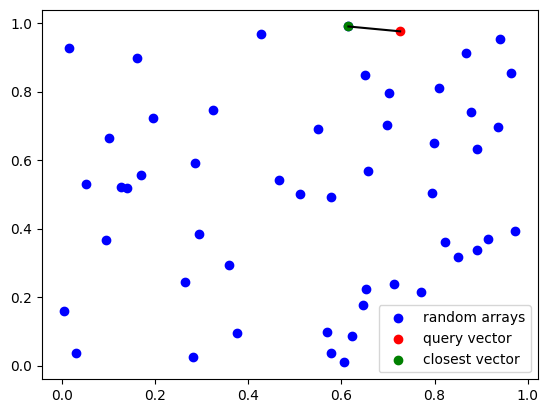

In [11]:
search_pipeline(arrays, query_vector, distance_l1)

## L2

In [12]:
def distance_l2(vec1, vec2):
    return np.linalg.norm(vec1-vec2, 2)

shortest_distance=0.11198825439556975
best_index=29


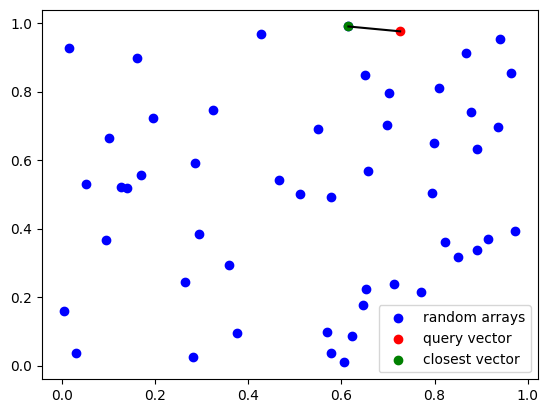

In [13]:
search_pipeline(arrays, query_vector, distance_l2)

## Dot product

In [14]:
from numpy import dot

In [15]:
def distance_dot(vec1, vec2):
    return 1-dot(vec1, vec2)

shortest_distance=-0.613752013350445
best_index=19


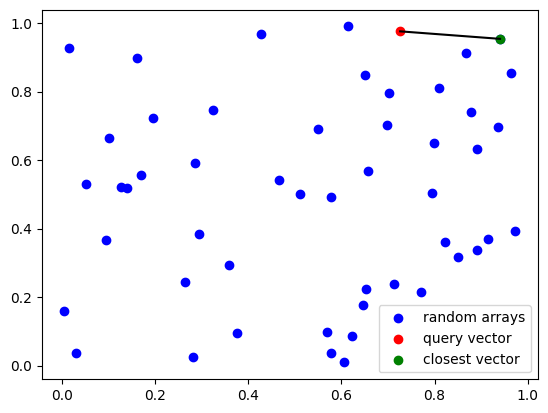

In [16]:
search_pipeline(arrays, query_vector, distance_dot)

## Cosine distance

In [17]:
from numpy.linalg import norm

In [18]:
def distance_cosine(vec1, vec2):
    return 1-dot(vec1, vec2)/(norm(vec1)*norm(vec2))

shortest_distance=8.576603896748303e-05
best_index=24


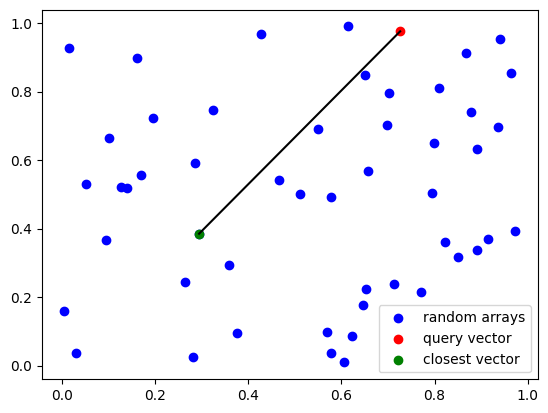

In [19]:
search_pipeline(arrays, query_vector, distance_cosine)

## Putting it all together

In [20]:
distance_functions = {
    "l1": distance_l1,
    "l2": distance_l2,
    "dot": distance_dot,
    "cosine": distance_cosine
}

# NSW

## Indexing

In [21]:
connected_nodes = {}
k = 2
distance_metric = "l2"

In [22]:
for i, arr in enumerate(arrays):
    # Find distances to all existing nodes in graph
    if distance_metric=="l1":
        distances = np.sum(np.abs((arrays[:i,] - arrays[i])), axis=1)
    elif distance_metric=="l2":
        distances = np.sqrt(np.sum((arrays[:i,] - arrays[i])**2, axis=1))
    elif distance_metric=="dot":
        distances = - dot(arrays[:i,], arrays[i])
    elif distance_metric=="cosine":
        distances = - dot(arrays[:i,], arrays[i]) / (norm(arrays[:i,], axis=1)*norm(arrays[i]))
    connected_nodes[i] = np.argsort(distances)[:k].tolist()
    for e in connected_nodes[i]:
        connected_nodes[e].append(i)

In [23]:
import networkx as nx

<ipython-input-24-62e29d45998a>:13: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


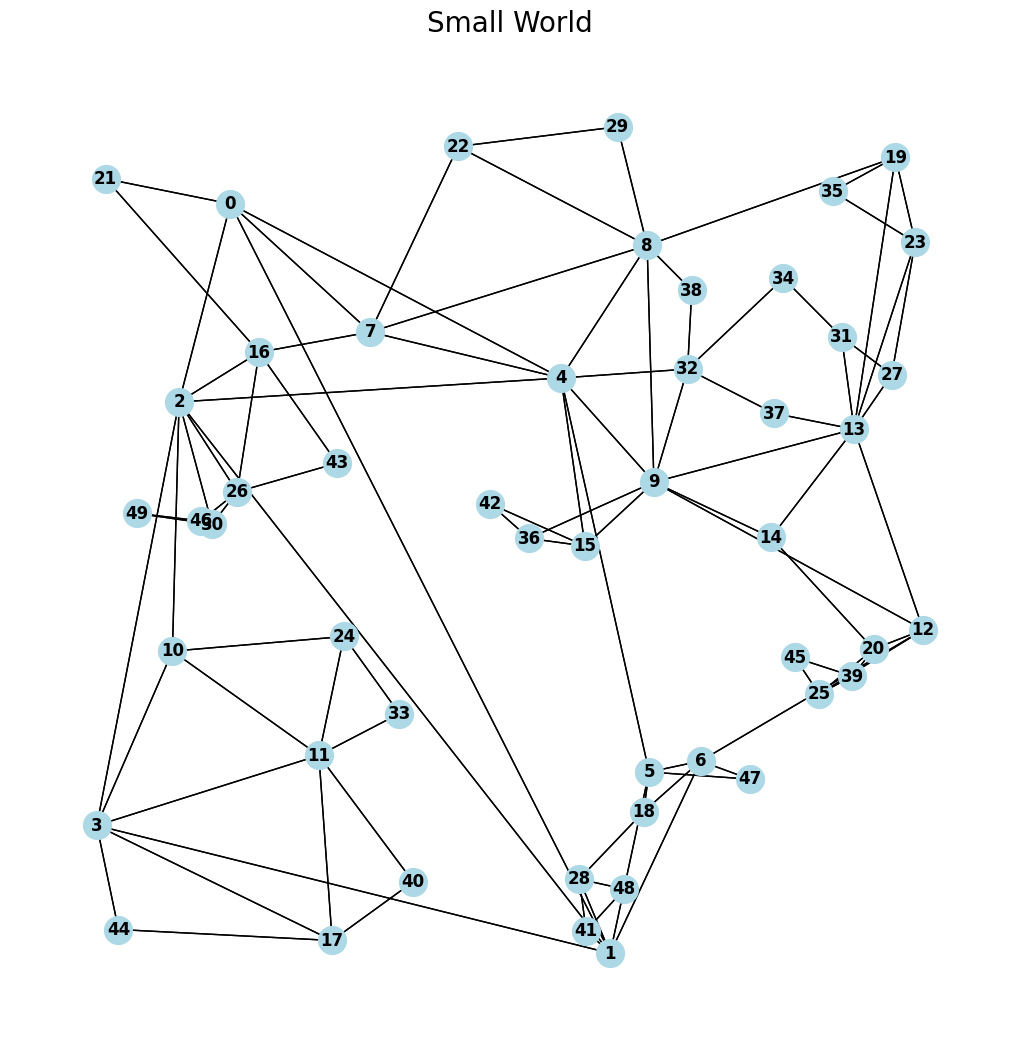

In [24]:
G = nx.Graph(connected_nodes)

# Create a dictionary of positions
pos = {i: arrays[i] for i in range(len(arrays))}

# Draw the graph
plt.figure(figsize=(10, 10))
nx.draw(G, pos, with_labels=True, node_color='lightblue',
        node_size=400, font_size=12, font_weight='bold')
nx.draw_networkx_edges(G, pos, width=1)
plt.title("Small World", fontsize=20)
plt.axis('off')
plt.tight_layout()
plt.show()

## Search

In [25]:
import random

In [26]:
distance_fn = distance_functions[distance_metric]

In [27]:
# Select a random node
starting_node = random.choice(list(connected_nodes))
# starting_node = 1
print(f"{starting_node=}")

starting_node=31


In [28]:
nodes_color = {i: 'lightblue' for i in connected_nodes}
nodes_color[starting_node] = 'pink'

In [29]:
distance_from_query = {
    starting_node: distance_fn(query_vector, arrays[starting_node])
}
distance_from_query

{31: 0.27955392732563605}

In [30]:
current_node = starting_node
min_distance = distance_from_query[starting_node]
loop_count = 0
while True:
    loop_count+=1
    # Find untranversed connected edges
    next_nodes = [n for n in connected_nodes[current_node] if n not in distance_from_query]
    print(f"{loop_count=}, {current_node=}, {next_nodes=}")
    if len(next_nodes)==0:
        break
    # Calculate distance and find new node
    new_node = None
    for n in next_nodes:
        # Update color
        nodes_color[n] = 'yellow'
        # Distance calculation
        distance = distance_fn(query_vector, arrays[n])
        distance_from_query[n] = distance
        if distance < min_distance:
            new_node = n
            min_distance = distance
    # Plot graph
    if new_node is not None:
        nodes_color[new_node] = 'green'
    G = nx.Graph(connected_nodes)
    pos = {i: arrays[i] for i in range(len(arrays))}
    # Add query node position
    query_node = len(connected_nodes)  # New node index
    pos[query_node] = query_vector
    plt.figure(figsize=(10, 10))
    nx.draw(G, pos, with_labels=True, node_color=[nodes_color[node] for node in G.nodes()],
            node_size=400, font_size=12, font_weight='bold')
    nx.draw_networkx_edges(G, pos, width=1)
    nx.draw_networkx_nodes(G, pos, nodelist=[query_node], node_color='red',
                       node_size=400)
    nx.draw_networkx_labels(G, pos, labels={query_node: 'Q'}, font_color='white',
                            font_size=12, font_weight='bold')
    plt.title("Small World", fontsize=20)
    plt.axis('off')
    plt.tight_layout()
    plt.savefig(f'small-world-from-node{starting_node}-query-{loop_count}.png', format='png', dpi=300, bbox_inches='tight')
    plt.close()
    nodes_color[new_node] = 'lightgreen'

    if new_node is None:
        break
    else:
        current_node = new_node

loop_count=1, current_node=31, next_nodes=[27, 13, 34]


<ipython-input-30-4bc646fd8d9e>:40: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


loop_count=2, current_node=34, next_nodes=[32]


In [31]:
print(f"final_node: {current_node}, distance={distance_from_query[current_node]}")

final_node: 34, distance=0.18548092853166145


# HNSW

## Indexing

In [32]:
from math import log

In [33]:
log_base = 3

In [34]:
n_levels = int(log(N, log_base))
n_levels

3

In [35]:
min_prob = np.array([log_base**(n_levels-i) for i in range(n_levels)])
min_prob = min_prob/np.sum(min_prob)
min_prob = np.concatenate(([0], np.cumsum(min_prob)[:-1]))
min_prob

array([0.        , 0.69230769, 0.92307692])

In [36]:
connected_nodes_hnsw = [{} for _ in range(n_levels)]
levels_nodes = [[] for _ in range(n_levels)]

for i, arr in enumerate(arrays):
    # Levels assigning
    assigned_levels = min_prob < random.random()

    for level in range(n_levels):
        if not assigned_levels[level]:
            break

        if distance_metric=="l1":
            distances = np.sum(np.abs((arrays[levels_nodes[level],] - arrays[i])), axis=1)
        elif distance_metric=="l2":
            distances = np.sqrt(np.sum((arrays[levels_nodes[level],] - arrays[i])**2, axis=1))
        elif distance_metric=="dot":
            distances = - dot(arrays[levels_nodes[level],], arrays[i])
        elif distance_metric=="cosine":
            distances = - dot(arrays[levels_nodes[level],], arrays[i]) / (norm(arrays[levels_nodes[level],], axis=1)*norm(arrays[i]))

        levels_nodes[level].append(i)
        connected_nodes_hnsw[level][i] = [levels_nodes[level][ix] for ix in np.argsort(distances)[:k].tolist()]

        for e in connected_nodes_hnsw[level][i]:
            connected_nodes_hnsw[level][e].append(i)

In [39]:
for level in range(n_levels):
    print(f"level-{i}, #nodes: {len(connected_nodes_hnsw[level].keys())}")

level-49, #nodes: 50
level-49, #nodes: 17
level-49, #nodes: 6


## Visualize

In [40]:
def create_color_mapper(n_levels):
    colormap = plt.cm.viridis  # You can change this to other colormaps like 'plasma', 'magma', etc.
    color_mapper = {}
    for level in range(n_levels-1, -1, -1):
        color_mapper[level] = colormap(level / (n_levels - 1))
    return color_mapper

In [41]:
def get_color(i, connected_nodes_level, levels_color):
    n_levels = len(connected_nodes_level)
    for level in range(n_levels-1, -1, -1):
        if i in connected_nodes_level[level]:
            return levels_color[level]

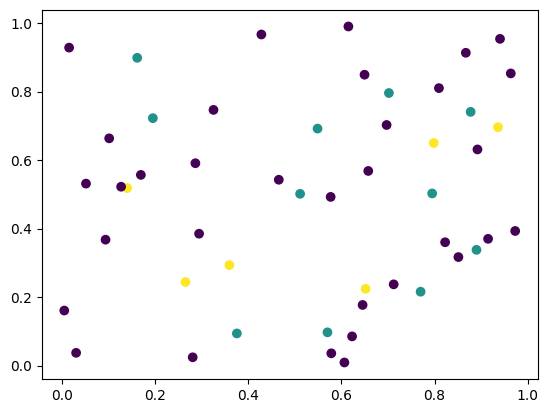

In [42]:
color_mapper = create_color_mapper(len(connected_nodes_hnsw))

plt.scatter(arrays[:,0], arrays[:,1], c=[get_color(i, connected_nodes_hnsw, color_mapper) for i in range(N)])
plt.show()

In [43]:
def plot_hnsw(graph, level=0):

    G = nx.Graph(graph[level])

    # Create a dictionary of positions
    pos = {i: arrays[i] for i in graph[level]}

    # Draw the graph
    plt.figure(figsize=(10, 10))
    nx.draw(G, pos, with_labels=True, node_color='lightblue',
            node_size=400, font_size=12, font_weight='bold')
    nx.draw_networkx_edges(G, pos, width=1)
    plt.title(f"Small World, Level-{level}", fontsize=20)
    plt.axis('off')
    plt.tight_layout()
    plt.show()

<ipython-input-43-2106b5c7a3c6>:15: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


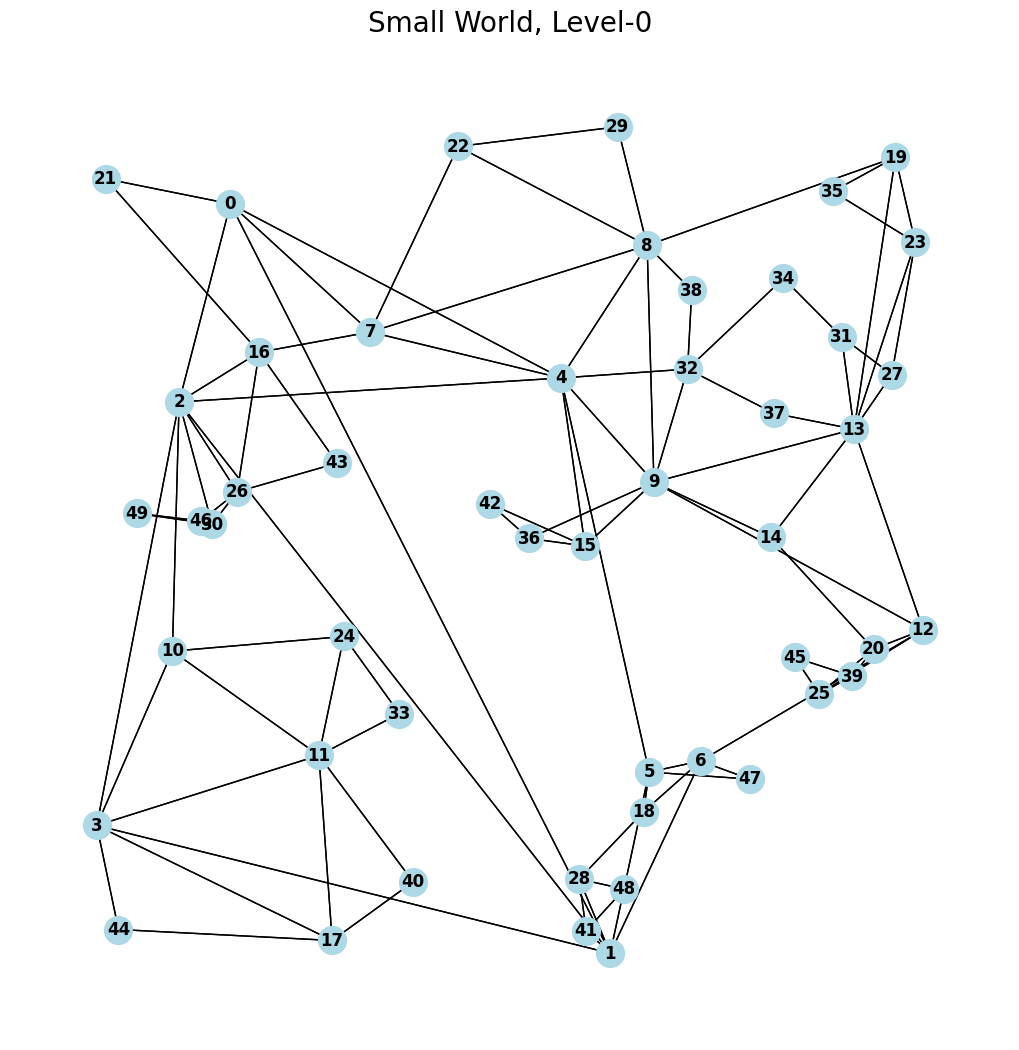

In [44]:
plot_hnsw(connected_nodes_hnsw, 0)

<ipython-input-43-2106b5c7a3c6>:15: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


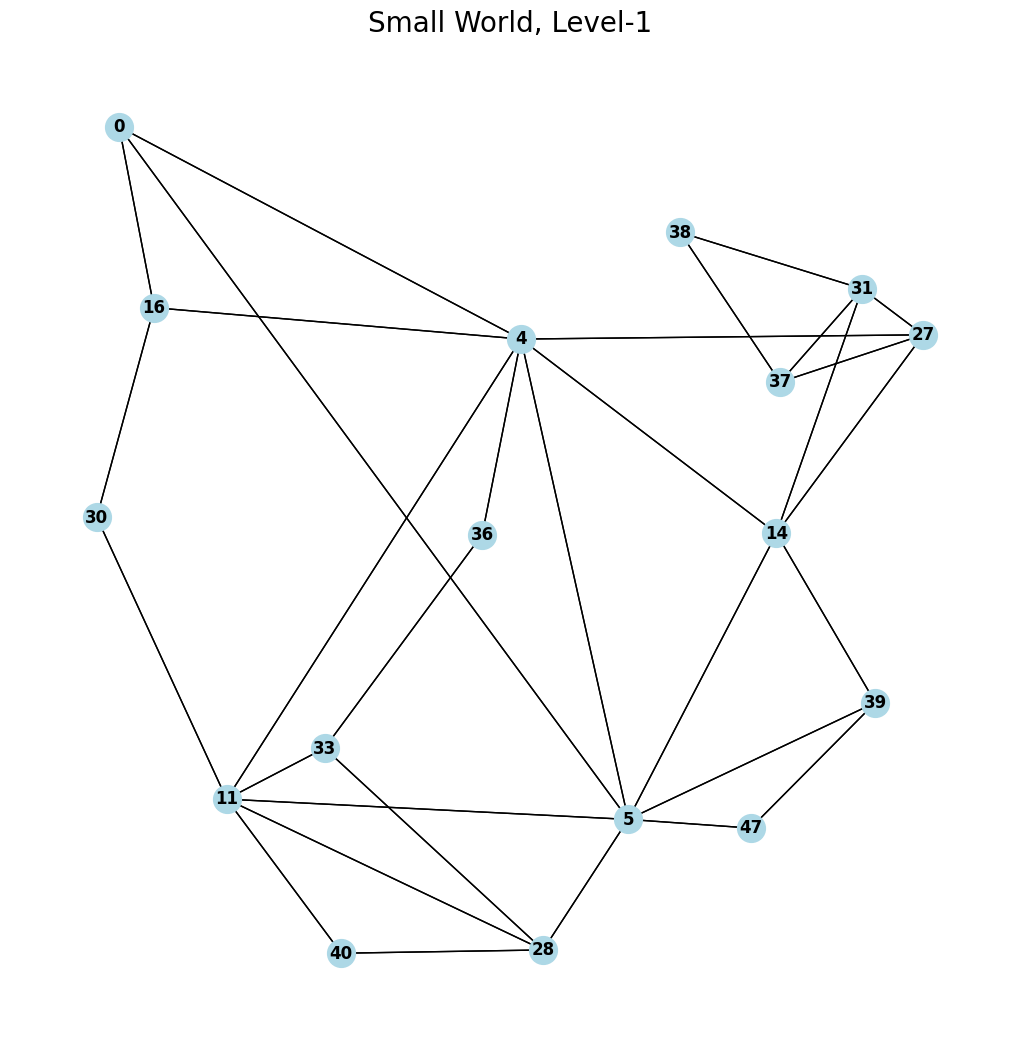

In [45]:
plot_hnsw(connected_nodes_hnsw, 1)

<ipython-input-43-2106b5c7a3c6>:15: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


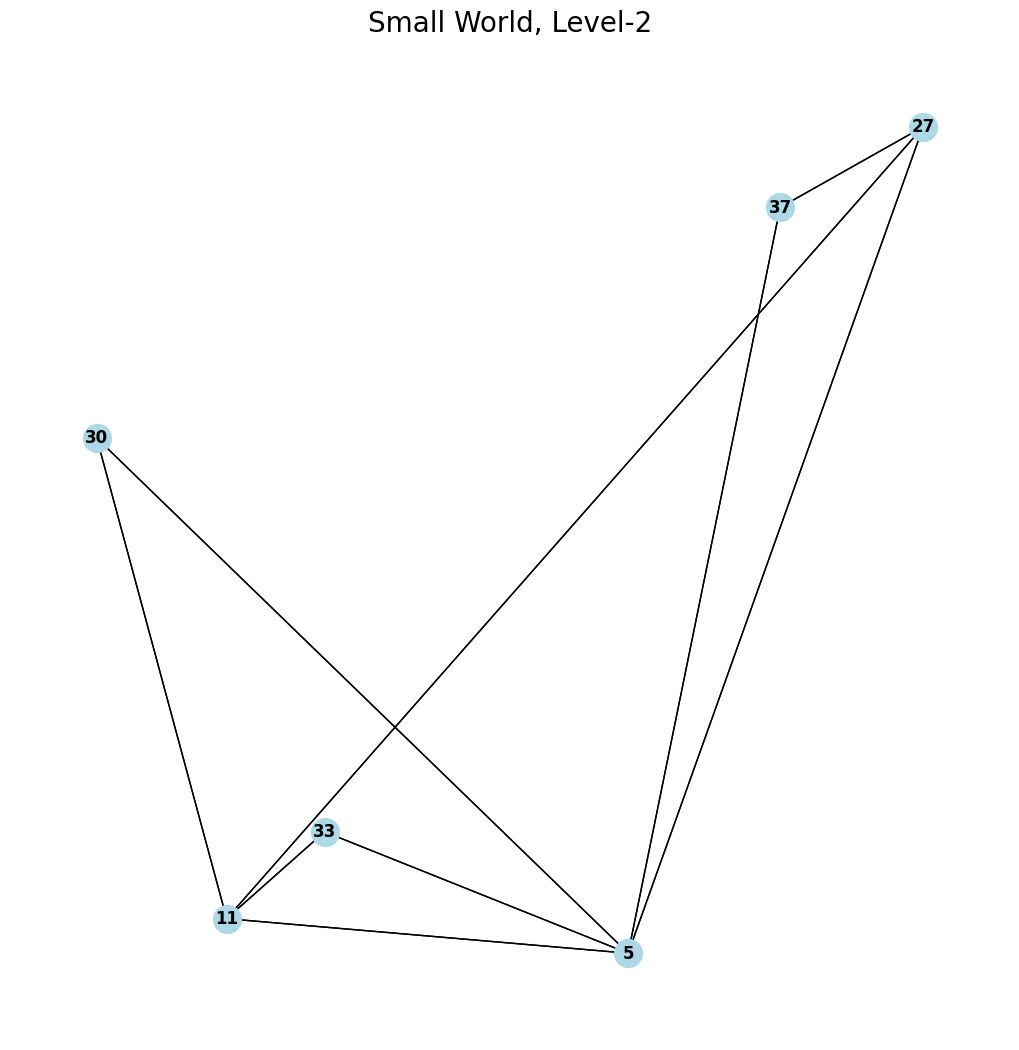

In [46]:
plot_hnsw(connected_nodes_hnsw, 2)

## Query

In [47]:
# Select a random node
starting_node = random.choice(list(connected_nodes_hnsw[2]))
starting_node = 30

In [48]:
nodes_color_hnsw = {i: 'lightblue' for i in connected_nodes}
nodes_color_hnsw[starting_node] = 'pink'

In [49]:
distance_from_query = {
    starting_node: distance_fn(query_vector, arrays[starting_node])
}
distance_from_query

{30: 0.7434590429994703}

In [50]:
current_node = starting_node
min_distance = distance_from_query[current_node]
loop_count = 0

for level in range(n_levels-1, -1, -1):
    while True:
        # Find untranversed connected edges
        next_nodes = [n for n in connected_nodes_hnsw[level][current_node] if n not in distance_from_query]
        if len(next_nodes)==0:
            print("no more nodes to explore")
            break
        loop_count+=1
        print(f"{loop_count=}, {level=}, {current_node=}")
        print(f"{next_nodes=}")
        # Calculate distance and find new node
        new_node = None
        for n in next_nodes:
            # Update color
            nodes_color_hnsw[n] = 'yellow'
            # Distance calculation
            distance = distance_fn(query_vector, arrays[n])
            distance_from_query[n] = distance
            if distance < min_distance:
                new_node = n
                min_distance = distance
        # Plot graph
        if new_node is not None:
            nodes_color_hnsw[new_node] = 'green'
        else:
            nodes_color_hnsw[current_node] = 'green'
            if current_node == starting_node:
                nodes_color_hnsw[current_node] = 'pink'
        G = nx.Graph(connected_nodes_hnsw[level])
        pos = {i: arrays[i] for i in range(len(arrays))}
        # Add query node position
        query_node = len(connected_nodes_hnsw[level])  # New node index
        pos[query_node] = query_vector
        plt.figure(figsize=(10, 10))
        nx.draw(G, pos, with_labels=True, node_color=[nodes_color_hnsw[node] for node in G.nodes()],
                node_size=400, font_size=12, font_weight='bold')
        nx.draw_networkx_edges(G, pos, width=1)
        nx.draw_networkx_nodes(G, pos, nodelist=[query_node], node_color='red',
                        node_size=400)
        nx.draw_networkx_labels(G, pos, labels={query_node: 'Q'}, font_color='white',
                                font_size=12, font_weight='bold')
        plt.title(f"Hierarchical Navigable Small World, Level{level}", fontsize=20)
        plt.axis('off')
        plt.tight_layout()
        filename = f'hnsw-query-{loop_count}-lvl{level}.png'
        plt.savefig(filename, format='png', dpi=300, bbox_inches='tight')
        plt.close()

        if new_node is None:
            nodes_color_hnsw[current_node] = 'lightgreen'
            if current_node == starting_node:
                nodes_color_hnsw[current_node] = 'pink'
            break
        else:
            nodes_color_hnsw[new_node] = 'lightgreen'
            current_node = new_node

loop_count=1, level=2, current_node=30
next_nodes=[11, 5]


<ipython-input-50-2d60541d4332>:48: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


loop_count=2, level=1, current_node=30
next_nodes=[16]
loop_count=3, level=1, current_node=16
next_nodes=[0, 4]
loop_count=4, level=1, current_node=4
next_nodes=[14, 27, 36]
loop_count=5, level=0, current_node=4
next_nodes=[2, 7, 8, 9, 15, 32]
loop_count=6, level=0, current_node=8
next_nodes=[19, 22, 29, 38]
no more nodes to explore


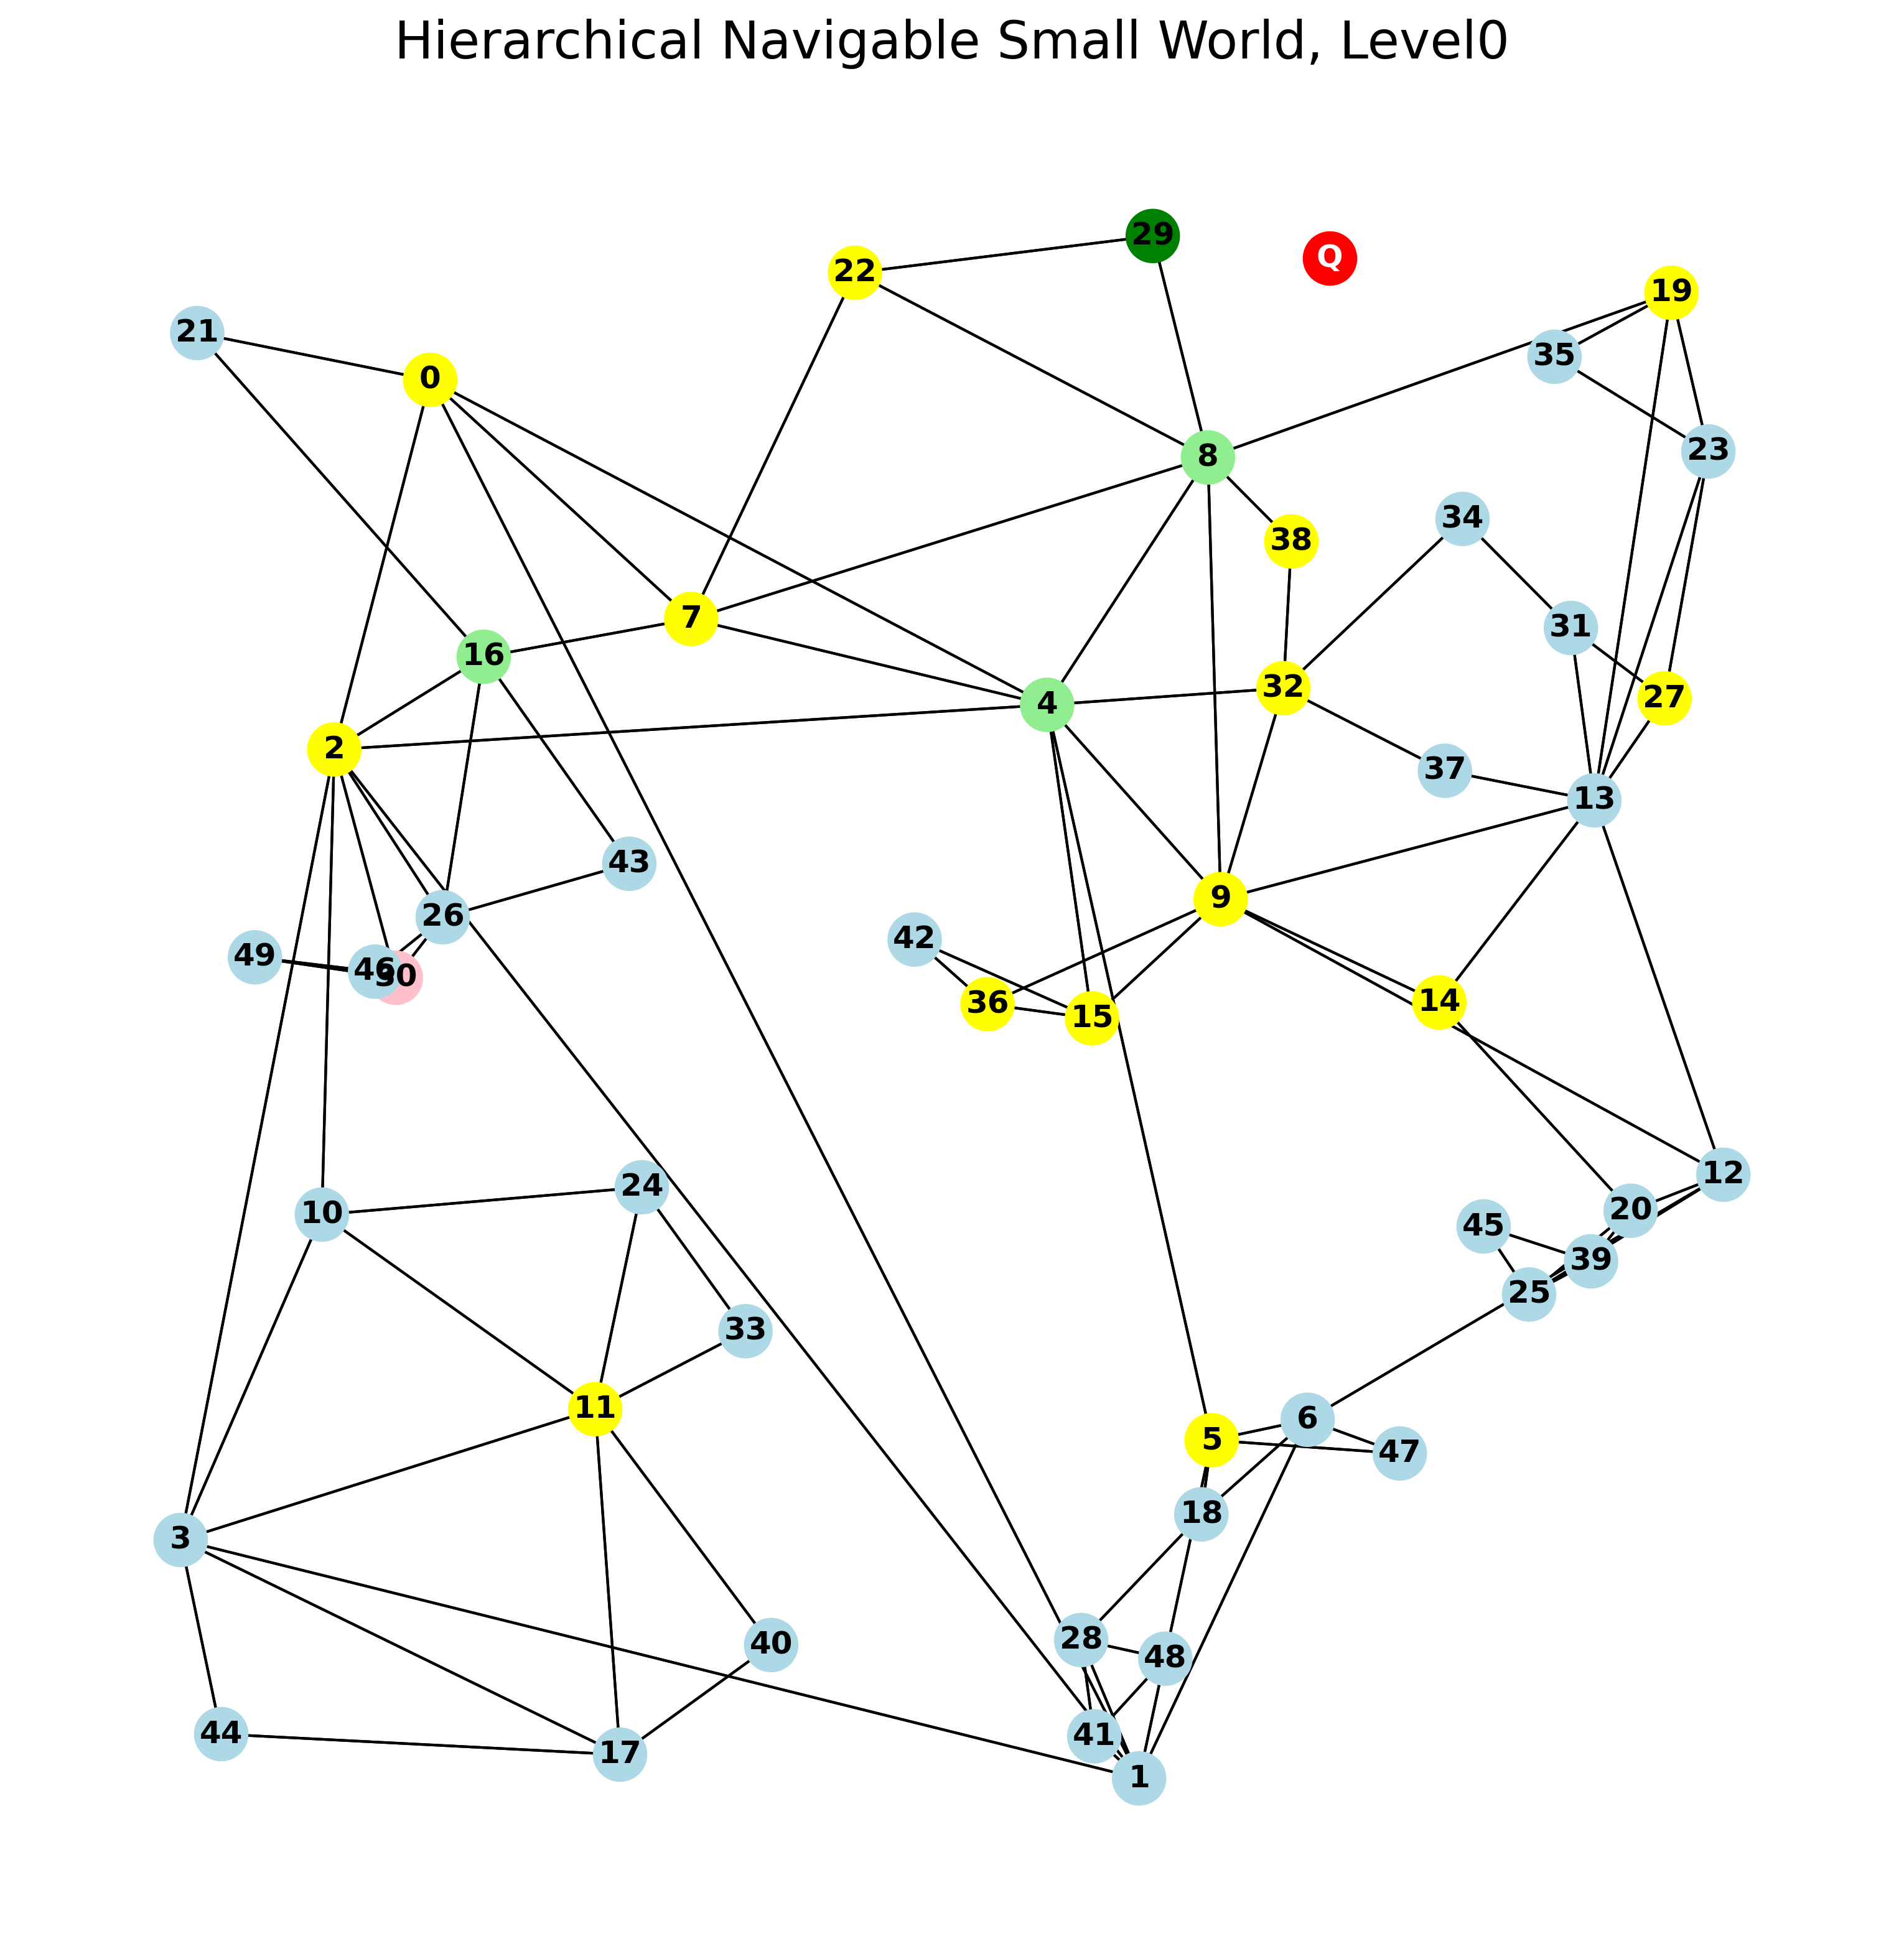

In [51]:
from PIL import Image
from IPython.display import display
img = Image. open(filename)
display(img)

# Tool

In [52]:
# !rm *.png